In [1]:
import numpy as np
from Turtlebot_Kinematics import *
import matplotlib.pyplot as plt


In [2]:
MAX_V = 22.2
translate_differential_drive(MAX_V, -MAX_V)

(0.0, -2.775)

In [3]:
from run_util import load_ENV
from environment import Environment
from time import time

In [4]:
ENV = load_ENV("simple", False)
ENV.set_robo_state(np.array([1000, 400, np.pi / 4]))

loading simple


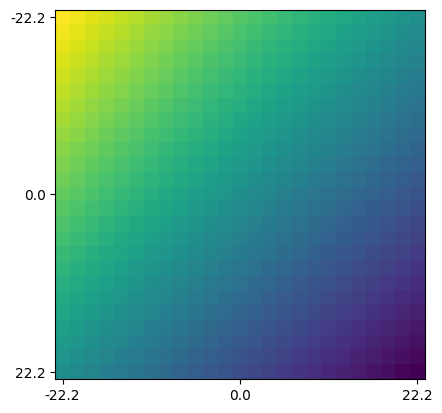

0.04652214050292969


In [5]:
dt = 1 / 20
v_space = np.linspace(-MAX_V, MAX_V, 25)
sensor_fusion = ENV.get_sensor_fusion()

# DWA like grid sampling
start_time = time()
fitness_grid = np.array([
    [ENV.fitness_single(pos=move_turtle(ENV.robo_state ,*translate_differential_drive(v_left, v_right), dt)[:2], sensor_fusion=sensor_fusion) for v_left in v_space]
    for v_right in v_space
])
process_time = time() - start_time

# rendering
fig, ax = plt.subplots()
im = ax.imshow(fitness_grid)
tick_locs = [0, int(len(v_space)/2), len(v_space)-1]
labels = [round(v, 1) for v in v_space[tick_locs]]
ax.set_xticks(tick_locs, labels=labels)
ax.set_yticks(tick_locs, labels=labels)
plt.show()
print(process_time)

In [6]:
from dwa_controller import DWA_Controller

DWA = DWA_Controller()

In [7]:
DWA(ENV)

(-22.2, 0.0)

In [8]:
from types import NoneType


MIN_V = - MAX_V
dt = 0.05

def generate_v_vector(horizon=10):
    v_range = 2 * MAX_V
    vec = np.array([MIN_V]*horizon*2) + np.random.rand(horizon*2) * v_range
    return vec

def translate_vector(vec):
    out = []
    for i in range(0,len(vec), 2):
        sub_vec = vec[i:i+2]
        trans_v = translate_differential_drive(*sub_vec)
        out.append(trans_v)
    return out

def fitness(vec, env=ENV, discount=0.98):
    trans_v_list = translate_vector(vec)
    positions = []
    cur_state = env.get_internal_state()
    sensor_fusion = env.get_sensor_fusion()
    overall_fit = 0
    for i, (v, w) in enumerate(trans_v_list):
        cur_pos = move_turtle(cur_state, v, w, dt)
        positions.append(cur_pos)
        fit = env.fitness_single(cur_pos[0:2], sensor_fusion=sensor_fusion)
        print((v,w), "->", fit)
        if fit >= env.collision_penalty:
            overall_fit += env.collision_penalty * (len(trans_v_list) - i)
        else: overall_fit += fit*discount**i
    return overall_fit, positions

def gen_swarm(horizon=10, pop_size=10):
    return [generate_v_vector(horizon) for _ in range(pop_size)]

def disturb(vec):
    return vec * np.random.rand(len(vec))

def apply_swarm_forces(ind, ind_best, global_best, velocity, inertia=0.5, cog=0.5, soc=0.5):
    new_velocity = velocity * inertia + cog * disturb(ind_best - ind) + soc * disturb(global_best - ind) 
    new_ind = ind + new_velocity
    for i in range(len(new_ind)):
        val = new_ind[i]
        if val >= MAX_V:
            new_ind[i] = MAX_V
            new_velocity[i] = 0
        elif val <= MIN_V:
            new_ind[i] = MIN_V
            new_velocity[i] = 0
    return new_ind, new_velocity

def particle_swarm_optimization(env:Environment, pop, charged_pop=[], iterations=100):
    # ATTENTION!: fitness is minimized
    sensor_fusion = env.get_sensor_fusion()
    fit = lambda state: env.fitness_single(state[:2], sensor_fusion)
    # TODO: make compatible with charged particles
    velocities = [np.zeros_like(ind) for ind in pop]
    individual_best = list(pop)
    individual_fit = [fit(ind) for ind in individual_best]
    global_best = individual_best[np.argmin(individual_fit)]
    global_fit = np.min(individual_fit)
    for iteration in range(iterations):
        new_pop = []
        for i,ind in enumerate(pop):
            new_ind, velocities[i] = apply_swarm_forces(ind, individual_best[i], global_best, velocities[i])
            new_pop.append(new_ind)
            new_fit = fit(new_ind)
            if new_fit < individual_fit[i]:
                individual_fit[i] = new_fit
                individual_best[i] = new_ind
                if new_fit < global_fit:
                    global_fit = new_fit
                    global_best = new_ind
        if iteration % 20 == 19:
            print(f"#{iteration}:", global_fit, "\n", individual_best, "\n")
    print("VELOCITIES:", velocities)
    return global_best, global_fit


pop = gen_swarm()
particle_swarm_optimization(ENV, pop)


#19: 470.4090040710435 
 [array([ 22.2       ,  19.9524495 ,  -1.02329137,  -8.01810764,
        10.08325269,  -0.0626383 ,   9.05411561,   9.27137149,
       -13.69671983,  -4.78725347, -17.75717891,  13.85421613,
        -3.25689595,  13.89000324,   1.89431202,   7.46623719,
       -15.2857931 ,  -3.59013349,   9.60082982,  15.89335001]), array([ 21.84287015,  18.02007628,   1.32312384,  -4.86519045,
        10.19685844,  -0.08071853,  16.45398126,   9.77658267,
        -7.12357708,  -2.24671237, -22.2       ,   8.02256295,
        -2.20854672,   8.9789205 ,  10.42092555,  -0.84967555,
        -4.7890576 ,  -2.05269203,  11.00362999,  13.49681595]), array([ 22.2       ,  22.2       ,   6.56290659,  -5.26012872,
         8.38741228,  -3.00069913,  14.94411147,  13.13675811,
        -8.12660076,  -1.9948828 , -17.52981161,   4.57690517,
        -2.06217693,   9.82948766,   5.47708882,   8.53034888,
       -18.730303  ,   3.18714856,  11.73728671,  12.99295133]), array([ 22.2       ,  2

(array([ 22.2       ,  22.2       ,   6.56290659,  -5.26012872,
          8.38741228,  -3.00069913,  14.94411147,  13.13675811,
         -8.12660076,  -1.9948828 , -17.52981161,   4.57690517,
         -2.06217693,   9.82948766,   5.47708882,   8.53034888,
        -18.730303  ,   3.18714856,  11.73728671,  12.99295133]),
 470.4090040710435)

In [9]:
from pso_controller import Multi_PSO_Controller
from timeit import timeit

mpso = Multi_PSO_Controller()
sensor_fusion = ENV.get_sensor_fusion()

own_best = mpso.generate_v_vector(10)
global_best = mpso.generate_v_vector(10)
print("fitness:", timeit(lambda: mpso.fitness(generate_v_vector(10), ENV, sensor_fusion=sensor_fusion), number=1000))
print("forces:", timeit(lambda: mpso.apply_swarm_forces(generate_v_vector(10), own_best, global_best, generate_v_vector(10)/10), number=1000))

fitness: 7.119131199999174
forces: 0.3307098999994196


In [1]:
state = ENV.get_internal_state()
v, w = translate_differential_drive(22.0, 15.0)
move_ = lambda: move_turtle(state, v, w, 0.05)
fit_ = lambda: ENV.fitness_single(state[0:2], sensor_fusion=sensor_fusion)

print("mov:", timeit(move_))
print("fit:", timeit(fit_))

NameError: name 'ENV' is not defined

In [18]:
from dwa_controller import*
from environment import*
from run_util import load_ENV

ENV = load_ENV("simple copy", False)
DWA = DWA_Controller()

print(DWA.fitness(ENV, ENV.get_internal_state(), 22.0, 0, 0.5))
print(ENV.get_internal_state())
print(DWA.fitness(ENV, ENV.get_internal_state(), -22.0, 0, 0.5))
print(ENV.get_internal_state())

loading simple copy
186.00485429040978
[650.92600948 377.09646841   5.02700172]
153.15450172638737
[650.92600948 377.09646841   5.02700172]


In [19]:
from pso_controller import Multi_PSO_Controller
import numpy as np

PSO = Multi_PSO_Controller(horizon = 1)
for _ in range(5):
    PSO(ENV)

fit=2151.804678931483 | [22.2 22.2]
__call__ 0.2420060634613037
fit=2151.804678916086 | [22.2 22.2]
__call__ 0.22408127784729004
fit=2151.8046789130044 | [22.2 22.2]
__call__ 0.2239980697631836
fit=2151.8046789310943 | [22.2 22.2]
__call__ 0.22300267219543457
fit=2151.804678909922 | [22.2 22.2]
__call__ 0.22300004959106445


In [22]:
c_pop = PSO.gen_swarm()
print(c_pop)

def comfortable_distance(x1, x2, d, k):
    out = (-k * np.linalg.norm(x1 - x2) - d) * (x1 - x2)
    print(type(out), out)
    return out

def function_3(x1, x2, d, a=20, b=22):
    c = d**2 / np.log(b/a)
    return (a - (b * np.exp(- np.linalg.norm(x1-x2)**2 / c))) * (x2 - x1)

def apply_charged_forces(c_pop, pop=[], d=10):
    new_c_pop = []
    for i, x1 in enumerate(c_pop):
        total_force = np.zeros_like(x1)
        for j, x2 in enumerate(c_pop + pop):
            if i != j:
                total_force += comfortable_distance(x1, x2, d, 0.2)
        new_c_pop.append(x1 + total_force / (len(c_pop + pop) - 1))
    return new_c_pop

        

[array([ 12.12065865, -15.32433688]), array([ 11.2201997 , -21.87450923]), array([-4.71525487,  6.35918943]), array([-20.83398239,  -0.89339622]), array([ -3.77582399, -12.83527991]), array([14.1340625, -4.8619743]), array([ 2.40040929, -1.21689319]), array([-9.34422268, 13.54861004]), array([7.44281554, 5.85188876]), array([-16.76098691, -12.70197526]), array([-6.4261878 , -4.05104169]), array([-20.20022012, -15.54750509]), array([ 8.30846366, -6.09838586]), array([ 15.07824267, -13.23599259]), array([15.71725923, 12.9133603 ]), array([-22.0774688 ,  12.33329852]), array([-17.35087644,  11.4970805 ]), array([ 6.73510727, -7.60236821]), array([-5.58813787, -1.74816806]), array([22.2, 22.2])]


<class 'numpy.ndarray'> [-10.19531607 -74.16337822]
<class 'numpy.ndarray'> [-260.79570888  335.8873642 ]
<class 'numpy.ndarray'> [-566.66052952  248.14242301]
<class 'numpy.ndarray'> [-210.1202474    32.90043949]
<class 'numpy.ndarray'> [ 24.42433378 126.91752615]
<class 'numpy.ndarray'> [-130.5078306   189.41200007]
<class 'numpy.ndarray'> [-369.09982554  496.48537564]
<class 'numpy.ndarray'> [-67.06786572 303.61092177]
<class 'numpy.ndarray'> [-456.33261219   41.43355079]
<class 'numpy.ndarray'> [-265.97739152  161.66854335]
<class 'numpy.ndarray'> [-532.14160882   -3.67431503]
<class 'numpy.ndarray'> [-45.7330238  110.67918571]
<class 'numpy.ndarray'> [31.71746476 22.39563983]
<class 'numpy.ndarray'> [ 56.44204489 443.1388295 ]
<class 'numpy.ndarray'> [-642.80482358  519.866518  ]
<class 'numpy.ndarray'> [-529.59884925  481.97665093]
<class 'numpy.ndarray'> [-63.99597728  91.75939403]
<class 'numpy.ndarray'> [-256.11872188  196.34936794]
<class 'numpy.ndarray'> [179.11888447 666.84

C:\Users\User\AppData\Local\Temp\ipykernel_20584\4248789956.py:19: RuntimeWarning: invalid value encountered in add
  total_force += comfortable_distance(x1, x2, d, 0.2)


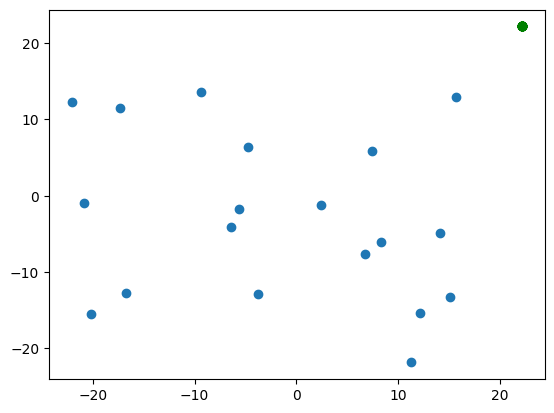

In [23]:
import matplotlib.pyplot as plt

pop = PSO.individual_best
new_c_pop = apply_charged_forces(c_pop, pop)
for _ in range(10):
    new_c_pop = apply_charged_forces(new_c_pop, pop)
plt.scatter([p[0] for p in c_pop], [p[1] for p in c_pop])
plt.scatter([p[0] for p in pop], [p[1] for p in pop], color="green")
plt.scatter([p[0] for p in new_c_pop], [p[1] for p in new_c_pop], color="red")

for i,x1 in enumerate(new_c_pop):
    s = 0
    for j,x2 in enumerate(new_c_pop + pop):
        if i != j:
            s += np.linalg.norm(x1 - x2)
    print(f"#{i+1}:\t{s/(len(new_c_pop + pop)-1)}")